In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import pandas as pd
import statsmodels.api as sm
import glob
import json
from pathlib import Path

In [91]:
import json
import os

# Load local config file
config_path = Path('config.json')
if not config_path.exists():
    raise FileNotFoundError("Missing config.json. Please create one with your local data path.")

with open(config_path, 'r') as f: 
    config = json.load(f)

# Access the data path
datadir = Path(config['data_path'])

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

In [92]:
def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def extract_neuron_profile(file_path):
    """
    Extracts neuron tuning profiles from a single HDF5 session file.

    Parameters:
    - file_path: str, path to the .h5 file

    Returns:
    - neuron_profile: pd.DataFrame with tuning betas, p-values, and metadata
    """
    # Load firing rates and metadata
    fr_CdN = pull_from_h5(file_path, 'CdN_zFR')
    fr_OFC = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([fr_CdN, fr_OFC], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'),
                              pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_CdN = fr_CdN.shape[2]
    n_OFC = fr_OFC.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'),
                                  pull_from_h5(file_path, 'OFC_locations')], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial selection
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Best-choice trials
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index()
    firing_single_best = firing_rates[mask.values, :, :]

    mean_FR = firing_single_best.mean(axis=1)  # shape: (n_trials, n_units)
    n_units = mean_FR.shape[1]

    # GLM design matrix
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    df['state_value_1'] = df['value'] * df['state_1']
    df['state_value_2'] = df['value'] * df['state_2']
    df['state_value_3'] = df['value'] * df['state_3']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = df[tuning_cols].astype(int)
    X = sm.add_constant(X)

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(n_units):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Assemble neuron profile
    neuron_profile = pd.DataFrame({
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    return neuron_profile

def compute_mean_density(neuron_profile, target_neuron=1, step_size=50, win_size=50):
    u_mask = (neuron_profile['value_correlation'] == target_neuron)
    all_u_depth = neuron_profile['depth']
    target_u_depths = neuron_profile[u_mask]['depth']

    half_depth = (all_u_depth.max() - all_u_depth.min()) / 2
    distances = np.arange(-half_depth, half_depth + 1, step_size)

    all_u_centric_densities = []

    for u in range(len(target_u_depths)):
        center_depth = target_u_depths.iloc[u]
        window_masks = [(all_u_depth >= center_depth + d - win_size) & 
                        (all_u_depth < center_depth + d + win_size) 
                        for d in distances]
        window_masks = np.stack(window_masks)
        target_neuron_mask = u_mask.astype(float)
        u_counts = window_masks.sum(axis=1)
        
        # Avoid division by zero by using np.where and assigning NaN where count is 0
        numerator = window_masks @ target_neuron_mask  # your numerator array
        denominator = u_counts  # your denominator array

        # Initialize result with NaNs
        u_centric_densities = np.full_like(numerator, np.nan, dtype=float)

        # Only divide where denominator is non-zero
        valid = denominator != 0
        u_centric_densities[valid] = numerator[valid] / denominator[valid]

        all_u_centric_densities.append(u_centric_densities)
        
        if u == 0:
            '''
            plt.figure(figsize=(8, 4))
            plt.plot(distances, u_centric_densities, marker='o')
            plt.title(f'Density profile around neuron {u} (target={target_neuron})')
            plt.xlabel('Relative depth (µm)')
            plt.ylabel('Fraction of target neurons')
            plt.grid(True)
            plt.show()
            '''
            print("First neuron's center depth:", center_depth)
            print("Window counts:", u_counts)
            print("Density values:", u_centric_densities)

            '''
            sns.heatmap(window_masks, cmap='Greys', cbar=False)
            plt.title(f'Window positions relative to neuron at depth {center_depth:.1f} μm')
            plt.xlabel('Neuron Index')
            plt.ylabel('Window Center Position Index')
            plt.show()
            sns.heatmap(target_neuron_mask, cmap='bwr', cbar=False)
            plt.title('Target Neuron Coding Type (1=target, 0=other)')
            plt.xlabel('Neuron Index')
            plt.ylabel('Coding Type')
            plt.show()
            '''
        
 
    all_u_centric_densities = np.array(all_u_centric_densities)
    mean_density = all_u_centric_densities.mean(axis=0)
    return distances, mean_density

def plot_neuron_centric_density(neuron_profile, target_neuron=1, step_size=50, win_size=50):
    """
    Plots neuron-centric density of value-coding neurons.

    Parameters:
    - neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with 'coding_type', 'value_correlation', and 'depth' columns.
    - tarkget_neurons (int): Target neuron type to analyze (1 for positive, -1 for negative).
    - reference_filter (int): Reference neuron type to filter by (1 for positive, -1 for negative).
    """
    target_property = {1: 'Positive', -1: 'Negative'}[target_neuron]

    distances, mean_density = compute_mean_density(neuron_profile, target_neuron=target_neuron, 
                                                   step_size=step_size, win_size=win_size)

    # Plot the density curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=distances, y=mean_density, color='blue')
    plt.title(f'Fraction of {target_property} Neurons Relative to {target_property} Neurons. Step {step_size}, Win {win_size}')
    plt.xlabel('Relative Depth (μm)')
    plt.ylabel(f'Fraction of {target_property} Neurons')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def get_coding_type(neuron_profile, p_thresh=0.05):
    """Classify neurons based on their coding type using p-value thresholds.
    
    Parameters:
    neuron_profile (pd.DataFrame): DataFrame containing neuron profiles with p-values.
    p_thresh (float): Significance threshold for p-values.
    Returns:
    
    pd.DataFrame: Updated DataFrame with a new 'coding_type' column.
    """
    
    # State coding: any state term is significant
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )

    # Value coding: value term is significant, but not state coding
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)

    # state_value coding: any interaction term is significant, but not pure value coding
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)

    # Refine state coding: exclude neurons already classified as state_val_coding
    state_coding = state_coding & (~state_val_coding)
    
    neuron_profile['coding_type'] = 'none'  # default
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    return neuron_profile

def get_value_correlation(row):
    """
    Determine the value correlation of a neuron based on its coding type and beta coefficients.
    
    Parameters:
    row (pd.Series): A row from the neuron_profile DataFrame.
    only_significant (bool): If True, only consider the primary coding type for correlation.
    
    Returns:
    int or str: 1 for positive correlation, -1 for negative correlation, 'none' if no significant coding.
    """
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
            return 'none'

def plot_neuron_location_w_window(neuron_profile, coding_type, win_cen, win_size, color_col='value_correlation', random_seed=42):
    np.random.seed(random_seed)

    random_jitter = np.random.uniform(0, 1, size=neuron_profile.shape[0])
    none_mask = neuron_profile[color_col] == 'none'

    # Create scatter plot of neurons
    plt.figure(figsize=(2, 5))

    # Plot the rest using colormap
    plt.scatter(
        random_jitter[~none_mask],
        neuron_profile.loc[~none_mask, 'depth'],
        c=neuron_profile.loc[~none_mask, color_col],
        cmap='bwr',
        s=30,
        edgecolor='k',
        alpha=0.8
    )


    # Draw the window as a black rectangle
    win_bottom = win_cen + win_size
    plt.gca().add_patch(plt.Rectangle(
        (0, win_bottom),  # x, y
        1,                # width
        2 * win_size,     # height
        edgecolor='black',
        facecolor='none',
        linewidth=2
    ))

    # Final plot settings
    plt.title(f'{coding_type} coding neurons')
    plt.xlabel('Lateral (jittered)')
    plt.ylabel('Depth (μm)')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [93]:
data_files = find_h5_files(datadir)
print('data_files:')
for f in data_files:
    print(f)

file_path = data_files[0]
print('\nfile:', os.path.basename(file_path))

data_files:
D:\Projects\rotation_project\data2analyze\D20231219_Rec05.h5
D:\Projects\rotation_project\data2analyze\D20231221_Rec06.h5
D:\Projects\rotation_project\data2analyze\D20231224_Rec07.h5
D:\Projects\rotation_project\data2analyze\D20231227_Rec08.h5
D:\Projects\rotation_project\data2analyze\K20240707_Rec06.h5
D:\Projects\rotation_project\data2analyze\K20240710_Rec07.h5
D:\Projects\rotation_project\data2analyze\K20240712_Rec08.h5
D:\Projects\rotation_project\data2analyze\K20240715_Rec09.h5

file: D20231219_Rec05.h5


In [94]:
neuron_profile = extract_neuron_profile(file_path)
neuron_profile = get_coding_type(neuron_profile, p_thresh=0.05)
neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)
neuron_profile.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,const_pval,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,value_correlation
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,-0.099159,0.022040,...,2.248013e-11,2.077736e-14,6.079816e-02,9.673977e-01,0.094160,2.078615e-01,9.986050e-01,0.005114,value,1.0
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,-0.081586,0.009982,...,5.989415e-05,1.758840e-05,5.631881e-01,8.351927e-01,0.081044,4.696540e-01,6.971981e-01,0.056862,value,1.0
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,-0.052531,0.013681,...,9.104573e-01,8.879737e-01,7.135640e-01,2.858809e-01,0.434968,4.914496e-01,6.551969e-01,0.241084,none,none
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,-0.001663,-0.009664,...,1.709934e-03,6.889923e-04,7.876026e-01,1.666495e-01,0.979803,6.187850e-01,8.002154e-02,0.649476,value,-1.0
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,-0.116649,-0.118231,...,1.669017e-73,3.629804e-77,1.035456e-11,5.820229e-10,0.030000,3.192019e-13,1.375211e-09,0.039481,state_value,-1.0


### For animals

In [95]:
data_files = find_h5_files(datadir)

all_profiles = []
for file_path in data_files:
    profile = extract_neuron_profile(file_path)
    profile['session'] = file_path.split('\\')[-1].replace('.h5', '')
    all_profiles.append(profile)

all_neuron_profile = pd.concat(all_profiles, ignore_index=True)
all_neuron_profile = get_coding_type(all_neuron_profile, p_thresh=0.01)
all_neuron_profile['value_correlation'] = all_neuron_profile.apply(get_value_correlation, axis=1)
all_neuron_profile['animal'] = all_neuron_profile['session'].str[0]

First neuron's center depth: 4.3387978632679705
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9
 19 27 39 39 40 42 41 36 33 37 36 41 47 50 50 45 46 60 64 53 53 59 63 68
 74 76 71 69 64 56 51 53 51 50 57 58 58 52 54 61 47 52 63 57 66 67 55 51
 52]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.11111111
 0.15789474 0.2962963  0.33333333 0.30769231 0.25       0.16666667
 0.19512195 0.1944444

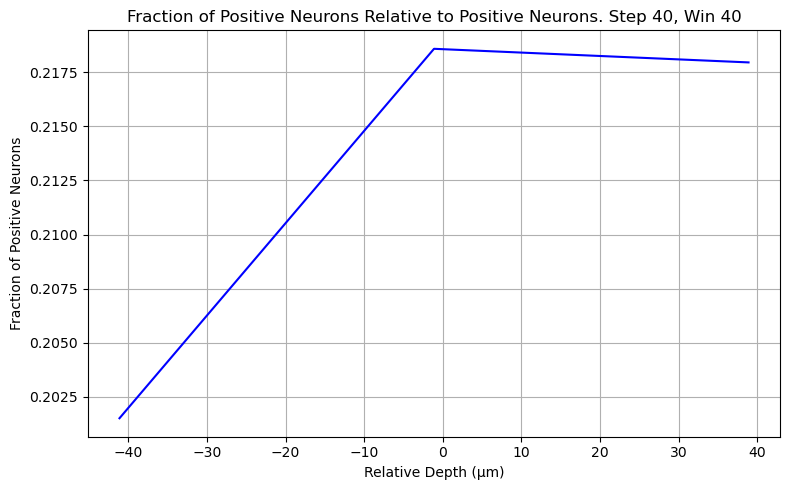

First neuron's center depth: 27.829871572013623
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 15
 28 31 37 45 43 41 32 32 42 38 41 42 45 49 47 53 49 55 67 50 51 70 67 67
 77 74 66 70 65 48 45 55 54 52 58 61 51 46 64 58 45 56 62 60 65 61 54 55
 59]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.5        0.2
 0.14285714 0.29032258 0.27027027 0.17777778 0.23255814 0.31707317
 0.34375    0.25       0.309

In [ ]:
animal_d_mask = all_neuron_profile['animal'] == 'D'
animal_k_mask = all_neuron_profile['animal'] == 'K'

plot_neuron_centric_density(all_neuron_profile[animal_d_mask], target_neuron=1, step_size=40, win_size=40)
plot_neuron_centric_density(all_neuron_profile[animal_d_mask], target_neuron=-1, step_size=40, win_size=40)

First neuron's center depth: 67.74317287751349
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 26
 43 50 45 52 59 49 31 32 40 42 43 44 49 51 47 38 40 39 39 50 38 37 45 44
 61 62 51 54 56 49 51 51 44 51 54 51 63 78 83 76 58 51 58 60 62 68 70 56
 51]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.         0.03846154
 0.18604651 0.22       0.2        0.15384615 0.16949153 0.2244898
 0.19354839 0.125      

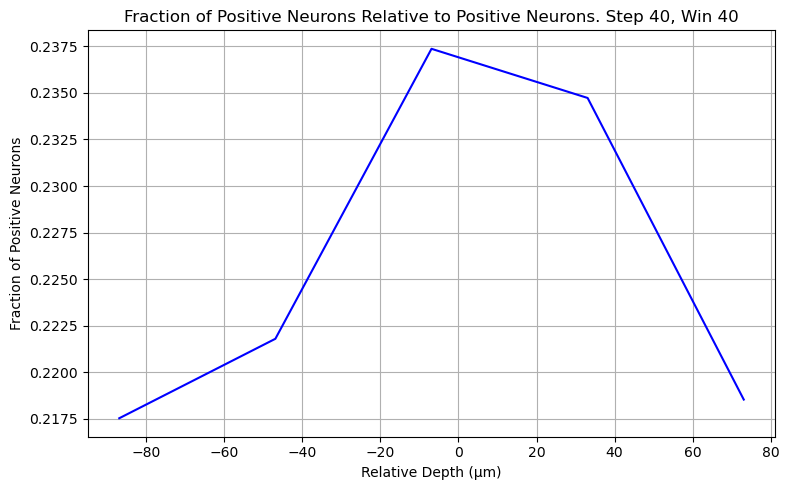

In [97]:
plot_neuron_centric_density(all_neuron_profile[animal_k_mask], target_neuron=1, step_size=40, win_size=40)

First neuron's center depth: 67.74317287751349
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 26
 43 50 45 52 59 49 31 32 40 42 43 44 49 51 47 38 40 39 39 50 38 37 45 44
 61 62 51 54 56 49 51 51 44 51 54 51 63 78 83 76 58 51 58 60 62 68 70 56
 51]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.         0.03846154
 0.18604651 0.22       0.2        0.15384615 0.16949153 0.2244898
 0.19354839 0.125      

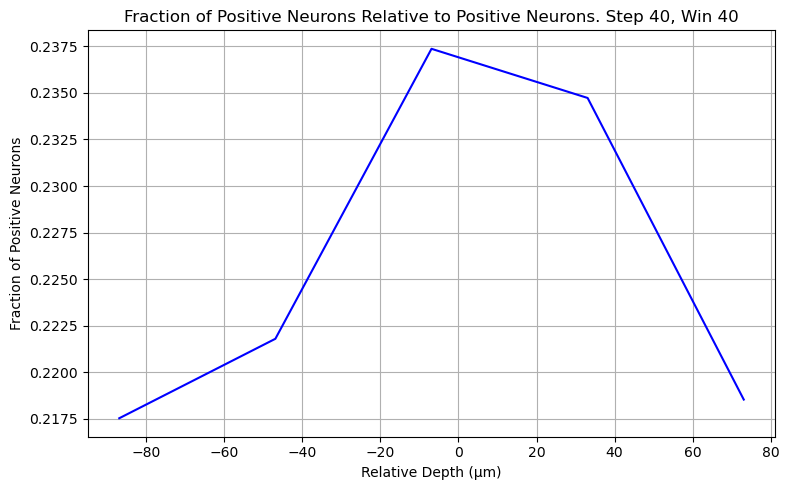

First neuron's center depth: -0.4857362514168564
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
 17 32 44 49 45 53 55 42 35 35 43 45 41 48 46 49 46 37 42 41 39 45 40 37
 44 49 59 58 54 59 53 45 52 50 44 52 54 60 70 72 75 75 62 52 58 61 62 68
 66]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.5
 0.41176471 0.3125     0.11363636 0.10204082 0.22222222 0.18867925
 0.18181818 0.26190476 0.22

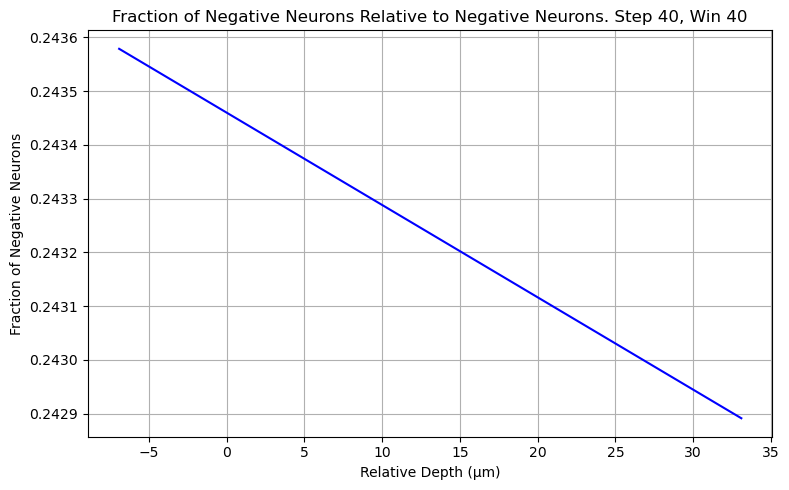

In [98]:
plot_neuron_centric_density(all_neuron_profile[animal_k_mask], target_neuron=1, step_size=40, win_size=40)
plot_neuron_centric_density(all_neuron_profile[animal_k_mask], target_neuron=-1, step_size=40, win_size=40)

First neuron's center depth: 4.3387978632679705
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9
 19 27 39 39 40 42 41 36 33 37 36 41 47 50 50 45 46 60 64 53 53 59 63 68
 74 76 71 69 64 56 51 53 51 50 57 58 58 52 54 61 47 52 63 57 66 67 55 51
 52]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.11111111
 0.15789474 0.2962963  0.33333333 0.30769231 0.25       0.16666667
 0.19512195 0.1944444

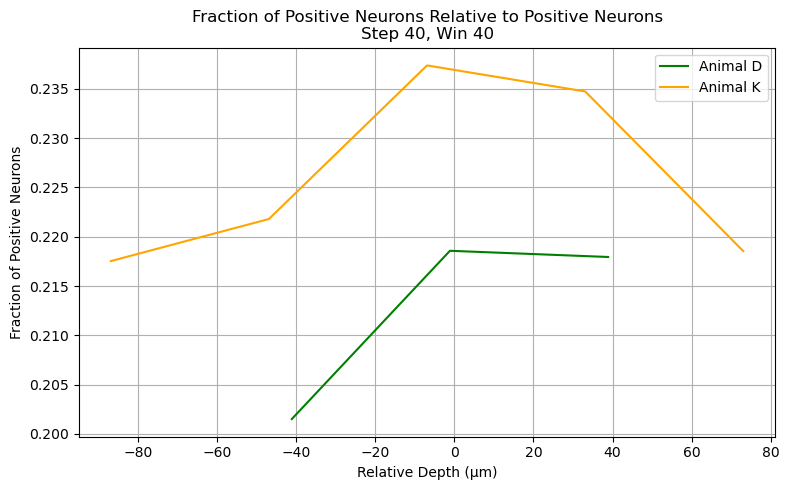

In [99]:
neurons_d = all_neuron_profile[animal_d_mask]
neurons_k = all_neuron_profile[animal_k_mask]
target_neuron = 1
step_size = 40
win_size = 40
distances_d, mean_density_d = compute_mean_density(neurons_d, target_neuron, step_size, win_size)
distances_k, mean_density_k = compute_mean_density(neurons_k, target_neuron, step_size, win_size)

target_property = {1: 'Positive', -1: 'Negative'}[target_neuron]

plt.figure(figsize=(8, 5))
sns.lineplot(x=distances_d, y=mean_density_d, label='Animal D', color='green')
sns.lineplot(x=distances_k, y=mean_density_k, label='Animal K', color='orange')
plt.title(f'Fraction of {target_property} Neurons Relative to {target_property} Neurons\nStep {step_size}, Win {win_size}')
plt.xlabel('Relative Depth (μm)')
plt.ylabel(f'Fraction of {target_property} Neurons')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

First neuron's center depth: 27.829871572013623
Window counts: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2 15
 28 31 37 45 43 41 32 32 42 38 41 42 45 49 47 53 49 55 67 50 51 70 67 67
 77 74 66 70 65 48 45 55 54 52 58 61 51 46 64 58 45 56 62 60 65 61 54 55
 59]
Density values: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.5        0.2
 0.14285714 0.29032258 0.27027027 0.17777778 0.23255814 0.31707317
 0.34375    0.25       0.309

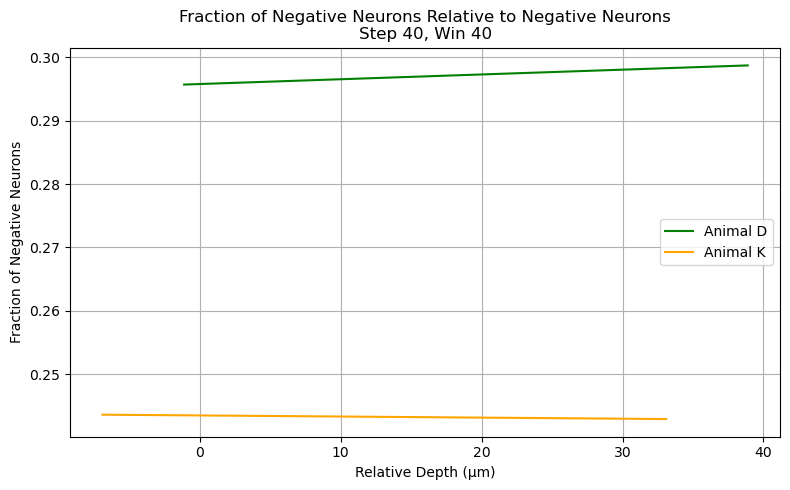

In [100]:
neurons_d = all_neuron_profile[animal_d_mask]
neurons_k = all_neuron_profile[animal_k_mask]
target_neuron = -1
step_size = 40
win_size = 40
distances_d, mean_density_d = compute_mean_density(neurons_d, target_neuron, step_size, win_size)
distances_k, mean_density_k = compute_mean_density(neurons_k, target_neuron, step_size, win_size)

target_property = {1: 'Positive', -1: 'Negative'}[target_neuron]

plt.figure(figsize=(8, 5))
sns.lineplot(x=distances_d, y=mean_density_d, label='Animal D', color='green')
sns.lineplot(x=distances_k, y=mean_density_k, label='Animal K', color='orange')
plt.title(f'Fraction of {target_property} Neurons Relative to {target_property} Neurons\nStep {step_size}, Win {win_size}')
plt.xlabel('Relative Depth (μm)')
plt.ylabel(f'Fraction of {target_property} Neurons')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
